In [58]:
import sys
sys.path.append(sys.path[0] + "/..")
import similarity_matrix
import pairwisecoverage
import submodular_sim
import math
import random
import pprint
import matplotlib.pyplot as plt
import mpmath
pp = pprint.PrettyPrinter()

This note book is ment to describe some numerical findings about determining $\gamma$. The goal is to be able to estimate $\gamma$ such that $\frac{H(S)}{G(S)}\leq (1+\gamma)$ and which method of selecting $S = \{x_1,...,x_n\} $ provides us the best approximiation bound for $f$. 


Assumptions:
$f$ is submodular and monotone

Since $f$ is monotone we can take 
$$G(S) = \sum_{x_i\in S}\max\{f(x_i) -\sum_{x_j\in S_i}f(x_i)-f(x_i|x_j),0\}$$

This is reasonable because if we take $$G(S) = \sum_{x_i\in S}\left(f(x_i) - \sum_{x_j\in S_i}\left(f(x_i)-f(x_i|x_j)\right)\right)$$ can be negative and provide us extra slack we dont want to work with.

Now assumming we are able to characturize each $f(x_i)-f(x_i|x_j) \leq w_{i,j}f(x_i)$ Then we can write our equation as 

$$G(S) \geq \sum_{x_i\in S}\max\{(1-\sum_{x_k\in S_i}w_{i,k}),0\}f(x_i)$$

This function is now a monotone submodular function and therefore exist a 1/2 approximiation to $G$.

The following goes through some numerical computations computing $\gamma$.

The following function computes the set $w_{i,j}$ corresponding to the set $S$ using the overlapping circles sensor model.

In [59]:
def compute_weights(S,a,b):
    S_i = []
    weight_sets = []
    total_sum = 0
    for s in S:
        weight_sets.append([pairwisecoverage.similarity_weight(pairwisecoverage.dist(s,s_j),a,b) for s_j in S_i])
        S_i.append(s)
        total_sum += sum(weight_sets[-1])
    #print("total:",total_sum)
    #pp.pprint(weight_sets)
    return weight_sets

This function computes the value of epsilon for a given set $S = \{x_1,...,x_n\}$
$$\sum_{x_i \in S} \min \{\sum_{x_k\in S_k\backslash\{y_i^{max}\}}w_{i,k} - w_i^{\max},1-w_i^{\max} \}f(x_i) \leq \epsilon\sum_{x_i \in S} (1-w_i^{\max})f(x_i)$$

More Specifically 

$$\frac{\sum_{x_i \in S} \min \{\sum_{x_k\in S_k\backslash\{y_i^{max}\}}w_{i,k} - w_i^{\max},1-w_i^{\max} \}f(x_i)}{\sum_{x_i \in S} (1-w_i^{\max})f(x_i)} = \epsilon$$

Then using this $\gamma$ can be computed using $\gamma = \frac{\epsilon}{1-\epsilon}$



In [60]:
def compute_eps_ratio_with_f(weight_sets,sim,S):
    total_LOWER = 0
    total_UPPER = 0
    avg_eps = 0 
    for i,weights in enumerate(weight_sets):
        if len(weights) == 0:
            continue
        elif len(weights)==1:
            total_UPPER += (1-weights[0])*sim.f([S[i]])
        else:
            max_weight = max(weights)
            avg_eps += (min([sum(weights)-max_weight,1-max_weight])*sim.f([S[i]]))/((1-max_weight)*sim.f([S[i]]))
            total_LOWER += min([sum(weights)-max_weight,1-max_weight])*sim.f([S[i]])
            total_UPPER += (1-max_weight)*sim.f([S[i]])
    #print("LOWER:",total_LOWER)
    #print("UPPER:",total_UPPER)
    eps = total_LOWER/total_UPPER
    #gamma = eps/(1-eps)
    #print("EPS:",eps)
    #print("1+gamma:",1+gamma)
    avg_eps = avg_eps/len(weight_sets)
    return eps

In [61]:
def compute_random_set(Xn):
    S_rand = []
    for X in Xn:
        S_rand.append(random.choice(X))
    return S_rand

def logspace(start, end, n):
    p = end/start
    return [start*math.pow(p,i/n) for i in range(n)]


The following function computes the expected distance between a point and the nth nearest sample given N points that are uniformly distributed over a cicle of radius R.

$$D_n = R\frac{\frac{\Gamma(n+\tfrac{1}{2})}{\Gamma(n)}}{\frac{\Gamma(N+1+\tfrac{1}{2})}{\Gamma(N+1)}}$$

This was taken from this paper, https://ieeexplore.ieee.org/document/5299075

The weights between two randomly sample points in a set can be then be computed using the expected distances.


In [62]:
def expected_distance(n,N,R):
    return R*(mpmath.gamma(n + 1/2)/mpmath.gamma(n))/(mpmath.gamma(N+1+1/2)/mpmath.gamma(N+1))

This function computes $\epsilon$ given a randomly selected set of points that were uniformly distributed. This also assumes that all the points selected have sensors the average area of $\frac{a+b}{2}$ where $a$ is the area of the smallest disk and $b$ is the area of the largest disk and the sizes of the disks are uniformly distributed over $[a,b]$. 

In [77]:
def compute_expected_eps(N,R,a,b):
    #R = math.sqrt(dims[0]*dims[1]/math.pi)
    total_lower = 0
    total_upper = 0
    
    f_avg = (a+b)/2
    for n in range(1,N):
        distances = [expected_distance(i,n,R) for i in range(1,n+1)]
        weights = [pairwisecoverage.similarity_weight(distances[i],a,b) for i in range(n)]
        total_upper +=(1-weights[0])*f_avg
        total_lower += min([sum(weights[:n+1])-weights[0],1-weights[0]])*f_avg
    
    #print("lower",total_lower)
    #print("upper",total_upper)
    eps = total_lower/total_upper
    #print(eps)
    gamma = eps/(1-eps)
    return eps

The follow compares a randomly sampled set bound to the greedy selected set and the expected case.

In [80]:
dims = (1000,1000)
sim = submodular_sim.submodular_sim(dims=dims)
a = 500
b = 500

ns = logspace(10,1000,10)
m = 10
greedy_gammas = []
rand_gammas = []
eps_greedy = []
eps_rand = []
print(ns)
expected_eps = []
D = 100
for n in ns:
    print("computing:",int(n))
    #Xn = [[{"x":random.random()*dims[0],"y":random.random()*dims[1],'r':random.uniform(math.sqrt(a/math.pi),        math.sqrt(b/math.pi))} for _ in range(m)] for _ in range(int(n))]
    Xn = [[{"x":D*random.random()*math.cos(2*math.pi*random.random()),"y":D*random.random()*math.sin(2*math.pi*random.random()),'r':random.uniform(math.sqrt(a/math.pi),        math.sqrt(b/math.pi))} for _ in range(m)] for _ in range(int(n))]
    S = sim.similarity_weight_greedy(Xn,a,b)
    S_rand = compute_random_set(Xn)
    #compute for greedy set
    
    weights_greedy = compute_weights(S,a,b)
    ep = compute_eps_ratio_with_f(weights_greedy,sim,S)
    eps_greedy.append(ep)
    print(ep)

    #compute for random set
    weights_rand = compute_weights(S_rand,a,b)
    ep = compute_eps_ratio_with_f(weights_rand,sim,S_rand)
    eps_rand.append(ep)
    print(ep)
    
    expected_eps.append(compute_expected_eps(int(n),D,a,b))

[10.0, 15.848931924611136, 25.118864315095802, 39.81071705534972, 63.095734448019336, 100.0, 158.48931924611134, 251.18864315095794, 398.1071705534973, 630.9573444801933]
computing: 10
0.0
0.0
computing: 15
0.0
0.005961925532611293
computing: 25
0.0
0.035398847962075104
computing: 39
0.003756122282989136
0.18164699283317176
computing: 63
0.03395777481007135
0.21652763969637234
computing: 100
0.1559947636417794
0.3416740092013491
computing: 158
0.3080541464198082
0.4428983454619765
computing: 251
0.48695722549504394
0.5415477641250608
computing: 398
0.5938667967499192
0.6187342327344
computing: 630
0.6901159866249655
0.6847750872742624


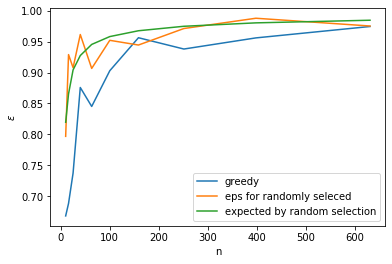

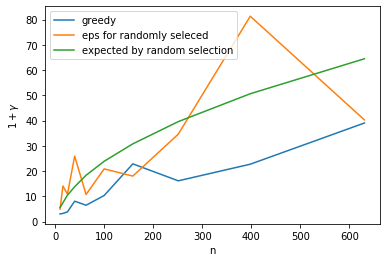

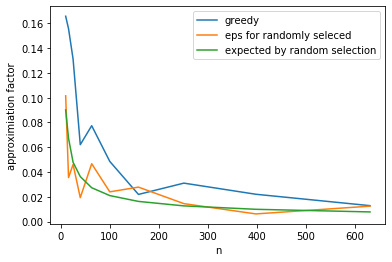

In [79]:
plt.plot(ns,eps_greedy)
plt.plot(ns,eps_rand)
plt.plot(ns,expected_eps)
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("n")
plt.ylabel(r"$\epsilon$")
plt.show()

plt.plot(ns,[1+ ep/(1-ep) for ep in eps_greedy])
plt.plot(ns,[1+ ep/(1-ep) for ep in eps_rand])
plt.plot(ns,[1+ ep/(1-ep) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("n")
plt.ylabel(r"$1 +\gamma$")
plt.show()

plt.plot(ns,[1/(2*(1+ ep/(1-ep))) for ep in eps_greedy])
plt.plot(ns,[1/(2*(1+ ep/(1-ep))) for ep in eps_rand])
plt.plot(ns,[1/(2*(1+ ep/(1-ep))) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("n")
plt.ylabel(r"approximiation factor")
plt.show()

In [81]:
dims = (100,100)
sim = submodular_sim.submodular_sim(dims=dims)
a = 500
b = 500
n = 50
d_s= logspace(100,5000,30)
d_s = [math.sqrt(d) for d in d_s]
m = 10
greedy_gammas = []
rand_gammas = []
eps_greedy = []
eps_rand = []
print(ns)
expected_eps = []
for d in d_s:
    print("computing:",int(d))
    Xn = [[{"x":d*random.random()*math.cos(2*math.pi*random.random()),"y":d*random.random()*math.sin(2*math.pi*random.random()),'r':random.uniform(math.sqrt(a/math.pi),        math.sqrt(b/math.pi))} for _ in range(m)] for _ in range(int(n))]
    S = sim.similarity_weight_greedy(Xn,a,b)
    S_rand = compute_random_set(Xn)
    #compute for greedy set
    
    weights_greedy = compute_weights(S,a,b)
    ep = compute_eps_ratio_with_f(weights_greedy,sim,S)
    eps_greedy.append(ep)
    print(ep)

    #compute for random set
    weights_rand = compute_weights(S_rand,a,b)
    ep = compute_eps_ratio_with_f(weights_rand,sim,S_rand)
    eps_rand.append(ep)
    print(ep)
    ep =compute_expected_eps(int(n),d,a,b)
    print(ep)
    expected_eps.append(ep)

[10.0, 15.848931924611136, 25.118864315095802, 39.81071705534972, 63.095734448019336, 100.0, 158.48931924611134, 251.18864315095794, 398.1071705534973, 630.9573444801933]
computing: 10
0.9479731812505056
0.9631887932413595
0.9580854783714
computing: 10
0.9031990105254174
0.9656584496457407
0.958145231674335
computing: 11
0.8940529403276603
0.9642263039778974
0.9582135922302746
computing: 12
0.8803539385157555
0.9328521214345216
0.958291848384646
computing: 12
0.8447988950078138
0.9063382114678098
0.9583814970235645
computing: 13
0.8672250472477753
0.8843356191035459
0.9584842825857927
computing: 14
0.9008994728433917
0.9791902724083885
0.9586022452023054
computing: 15
0.8761006217550603
0.9562482644458146
0.9566332076015023
computing: 16
0.8346822093590097
0.9440648627449928
0.9521452900399355
computing: 17
0.8537631441585785
0.9539031359556214
0.9480576381197736
computing: 19
0.8251884430242704
0.9036066944060451
0.9443646604907653
computing: 20
0.8103861785813474
0.8845173493960359
0

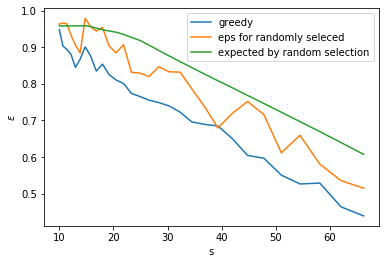

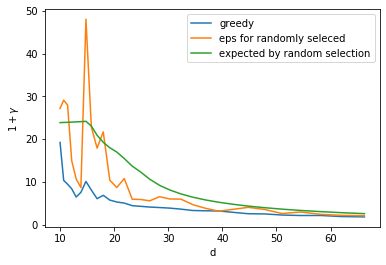

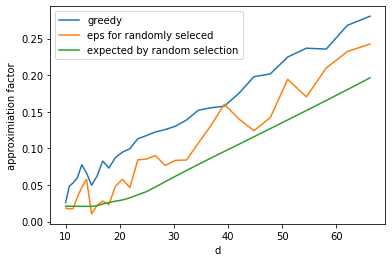

In [82]:
plt.plot(d_s,eps_greedy)
plt.plot(d_s,eps_rand)
plt.plot(d_s,expected_eps)
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("s")
plt.ylabel(r"$\epsilon$")
plt.show()

plt.plot(d_s,[1+ ep/(1-ep) for ep in eps_greedy])
plt.plot(d_s,[1+ ep/(1-ep) for ep in eps_rand])
plt.plot(d_s,[1+ ep/(1-ep) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("d")
plt.ylabel(r"$1 +\gamma$")
plt.show()

plt.plot(d_s,[1/(2*(1+ ep/(1-ep))) for ep in eps_greedy])
plt.plot(d_s,[1/(2*(1+ ep/(1-ep))) for ep in eps_rand])
plt.plot(d_s,[1/(2*(1+ ep/(1-ep))) for ep in expected_eps])
plt.legend(['greedy','eps for randomly seleced','expected by random selection'])
plt.xlabel("d")
plt.ylabel("approximiation factor")
plt.show()